In [1113]:
import pandas as pd
from functools import partial

from biom.util import biom_open
from sklearn.preprocessing import LabelEncoder
from biom import load_table
from gneiss.util import match
from deicode.preprocessing import rclr
from deicode.optspace import OptSpace
import seaborn as sns
import pandas as pd
import numpy as np
from skbio.stats.composition import clr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
plt.style.use('ggplot')
sns.set_style('whitegrid')


class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

%matplotlib inline

Intro TODO

In [1115]:
in_biom='data/keyboard/table.biom'
in_meta='data/keyboard/metadata.txt'

table = load_table(in_biom)
table = table.to_dataframe().T
meta = pd.read_table(in_meta,index_col=0)
meta = meta[meta['host_subject_id'].isin(['M9','M2'])]
meta['encoded_host_id']=LabelEncoder().fit_transform(meta.host_subject_id.values)
table,meta = match(table,meta)
table = table.T[table.sum()>5].T
table = table[table.T.sum()>500]
table,meta = match(table,meta)
table.shape


(67, 670)

TODO

In [1116]:
from gneiss.cluster._pba import correlation_linkage, gradient_linkage
from gneiss.sort import gradient_sort, mean_niche_estimator

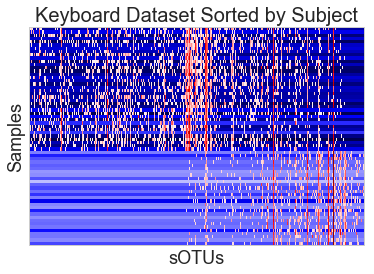

In [1117]:

table_grad = table.copy()
table_grad.sort_index()
c = pd.Series(meta['encoded_host_id'])
table, c = match(table_grad, c)
t = gradient_linkage(table_grad+1, c, method='average')
mean_g = mean_niche_estimator(table_grad, c)
mean_g = pd.Series(mean_g, index=table_grad.columns)
mean_g = mean_g.sort_values()

# plot the gradient
table_grad = table_grad.reindex(index=meta.sort_values('encoded_host_id').index,columns=mean_g.index)
plt.imshow(clr(table_grad+1),aspect='auto',norm=MidpointNormalize(midpoint=0.), cmap='seismic')
plt.title('Keyboard Dataset Sorted by Subject',fontsize=20)
plt.ylabel('Samples',fontsize=18)
plt.xlabel('sOTUs',fontsize=18)
plt.xticks([])
plt.yticks([])
plt.show()


TODO

In [1118]:
#PCoA and PERMANOVA
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
from scipy.spatial import distance
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
# blocks
from scipy.stats import norm
from numpy.random import poisson, lognormal
from skbio.stats.composition import closure
from scipy.special import kl_div
from scipy.stats import entropy
from random import shuffle


Example of subsample from 1100 mean reads per sample to ~1000 mean reads/sample

In [1124]:
sub_table = []
sub_table_plots = []
for depth_ in [500,100]:
    table_norm = table.copy()
    table_norm = pd.DataFrame(table_norm.values.astype(int),
                              table_norm.index,table_norm.columns)
    for ind_ in table_norm.index:
        table_norm.loc[ind_,:] = subsample_counts(table_norm.loc[ind_,:],int(depth_))
        
    save_ = table_norm.reindex(index=table_grad.index,columns=table_grad.columns)
    sub_table_plots.append(save_)
        
    table_norm.index = [str(count_)+'_'+y.split('.')[1][:2]+'_'+str(depth_) 
                        for count_, y in enumerate(table_norm.index)]
    sub_table.append(table_norm)

    
depths_table = pd.concat(sub_table,axis=0).fillna(0)
depths_meta = pd.DataFrame([[x.split('_')[1],int(x.split('_')[2])]
                             for x in depths_table.index],
                             index=depths_table.index, 
                             columns=['Subject','Depth'])
depths_meta['encoded_host_id']=LabelEncoder().fit_transform(depths_meta.Subject.values)


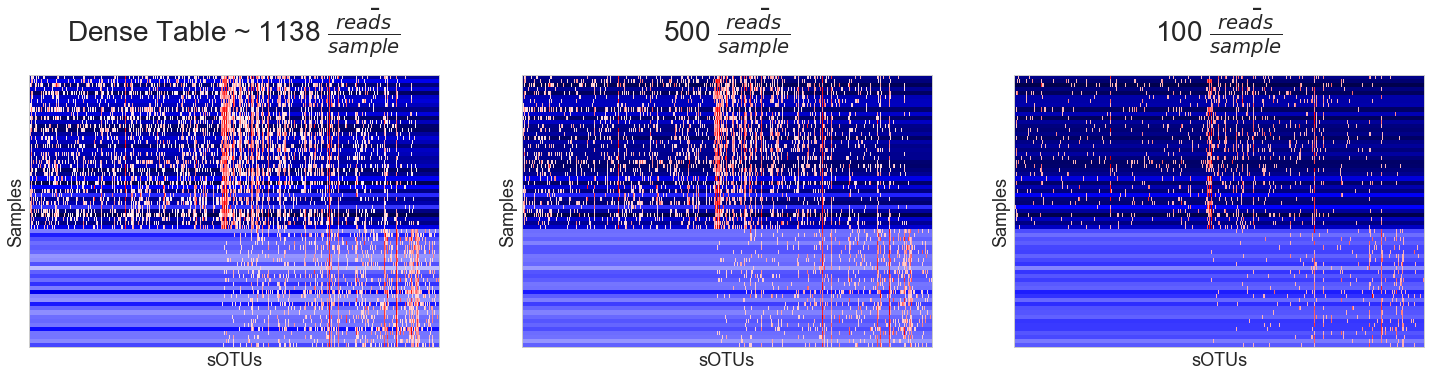

In [1139]:
fig,axn = plt.subplots(1,3,figsize=(25,5))

tables_plot = [table_grad]+sub_table_plots
random_titles = ['Dense Table ~ 1138 $\\bar{\\frac{reads}{sample}}$']+["500 $\\bar{\\frac{reads}{sample}}$", 
                                                               "100 $\\bar{\\frac{reads}{sample}}$"]

for ax_,table_plot,title_tmp in zip(axn.flat,tables_plot,random_titles):

    ax_.imshow(clr(table_plot+1),aspect='auto',norm=MidpointNormalize(midpoint=0.), cmap='seismic')
    ax_.set_title(title_tmp,fontsize=28,y=1.1)
    ax_.set_ylabel('Samples',fontsize=18)
    ax_.set_xlabel('sOTUs',fontsize=18)
    ax_.set_xticks([])
    ax_.set_yticks([])

plt.show()


In [ ]:
plt.rcParams["axes.labelsize"] = 26
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

fig,axn = plt.subplots(1,3,figsize=(20,5))
axn=axn.flatten()
count=0

markers = ["o" ,"s","^"]
colors_ = ['#377eb8','#4daf4a']
classes_1 = np.sort(list(set(depths_meta['Depth'])))
#create map for color
classes_2 = np.sort(list(set(depths_meta['Subject'])))
classes_2_color = {i:colors_[count_] for count_,i in enumerate(classes_2)}

for metric_,tit_ in zip(['jaccard','braycurtis'],['Jaccard','Bray–Curtis']):
    
    dis_ = pcoa(DistanceMatrix(pdist(depths_table,metric_))).samples
    dis_.index = depths_table.index
    dis_,depths_meta_tmp = match(dis_,depths_meta)

    ax = axn[count]

    for count_,sub_class in enumerate(classes_1):
        idx = depths_meta['Depth'] == sub_class 
        for sub_class_2 in classes_2:
            idx_2 = depths_meta['Subject'] == sub_class_2 
            idx_2 = idx&idx_2
            color_ = classes_2_color[sub_class_2]
            points = ax.scatter(dis_.loc[idx_2,'PC1'], dis_.loc[idx_2,'PC2'],s=50, 
                       c=color_,marker=markers[count_],label=sub_class)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
    ax.set_title(tit_,fontsize=35)
    count+=1

#RPCA
ax = axn[count]  
depths_table_rclr = rclr().fit_transform(depths_table.copy())
U_clr,s_clr,V_clr = OptSpace(rank=3,iteration=5).fit_transform(depths_table_rclr)
U_clr = pd.DataFrame(U_clr,depths_table.index,['PC1','PC2','PC3'])
U_clr,depths_meta_tmp = match(U_clr,depths_meta)

for count_,sub_class in enumerate(classes_1):
    idx = depths_meta['Depth'] == sub_class 
    for sub_class_2 in classes_2:
        idx_2 = depths_meta['Subject'] == sub_class_2 
        idx_2 = idx&idx_2
        color_ = classes_2_color[sub_class_2]
        points = ax.scatter(U_clr.loc[idx_2,'PC1'], U_clr.loc[idx_2,'PC2'],s=50, 
                   c=color_,marker=markers[count_],label=sub_class)
ax.set_title('RPCA',fontsize=35)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors_[i]) for i in range(len(colors_))]
handles += [f(markers[i], "k") for i in range(len(markers))]
labels = list(map(str,classes_2))  + ["500 $\\bar{\\frac{reads}{sample}}$", 
                                      "100 $\\bar{\\frac{reads}{sample}}$"]
plt.legend(handles, labels,loc=2, bbox_to_anchor=(1.0, 1.05),
           prop={'size':26},fancybox=True, framealpha=0.5,
           markerscale=2, facecolor="grey")

fig.savefig('figures/supp_2.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()
